In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV, train_test_split
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt

In [2]:
# Load the dataset
file_path = '/home/itsld/Documents/GitHub/AI_FOUND_TEAM_01/dataset/Data.csv' # Adjust the path to your dataset
data = pd.read_csv(file_path)

# Prepare the data
data['datetime'] = pd.to_datetime(data['datetime'], format='%m/%d/%Y')
data['day_of_year'] = data['datetime'].dt.dayofyear

# Extract features and labels
X = data[['temp', 'tempmax', 'tempmin', 'feelslikemax', 'feelslikemin', 'feelslike', 'sealevelpressure', 'humidity', 'day_of_year']]
y = data['feelslike']

# Train-test split (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create LightGBM Dataset
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# Initialize the LightGBM model
lgbm_model = LGBMRegressor(random_state=42)

# Define the parameter grid for fine-tuning
param_grid = {
    'num_leaves': [31, 50, 70],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 500],
    'max_depth': [3, 5, 7]
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=lgbm_model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Fit the model to the training data
grid_search.fit(X_train, y_train)

best_lgb_model = grid_search.best_estimator_

y_pred_lgb = best_lgb_model.predict(X_test)

r2_lgb = r2_score(y_test, y_pred_lgb)
rmse_lgb = mean_squared_error(y_test, y_pred_lgb, squared=False)
mae_lgb = mean_absolute_error(y_test, y_pred_lgb)

# Display the performance metrics for XGBoost
print(f"Lgbm- R² Score: {r2_lgb:.3f}")
print(f"Lgbm - RMSE: {rmse_lgb:.3f}")
print(f"Lgbm - MAE: {mae_lgb:.3f}")
print(f"Best Parameters: {grid_search.best_params_}")




Fitting 5 folds for each of 81 candidates, totalling 405 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000427 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1689
[LightGBM] [Info] Number of data points in the train set: 1084, number of used features: 9
[LightGBM] [Info] Start training from score 27.001661
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

/home/itsld/.local/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Predictions saved to 'feelslike_forecast_lgb_2024_tuned.csv'


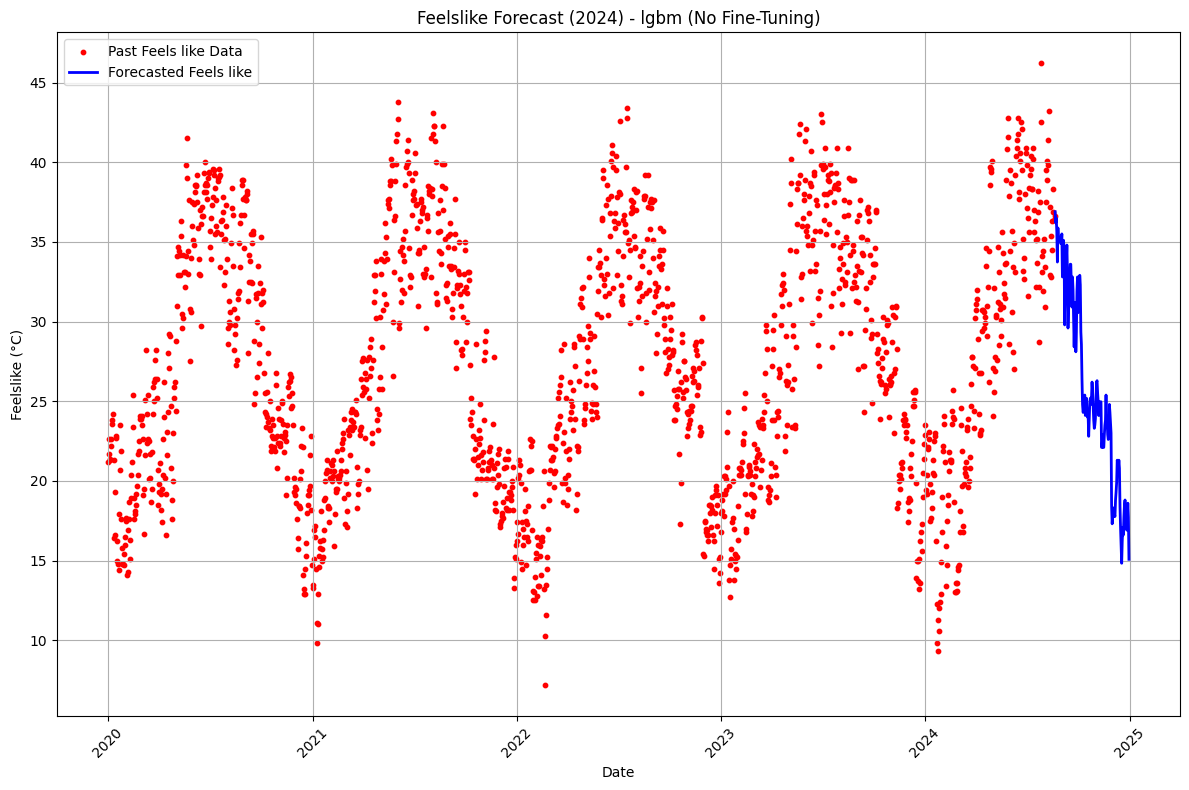

In [5]:
# Generate future dates (from 21/08/2024 to 31/12/2024)
future_dates = pd.date_range('2024-08-21', '2024-12-31')
future_day_of_year = future_dates.dayofyear
future_data = pd.DataFrame({
    'day_of_year': future_day_of_year,
    'year': future_dates.year
})

# Use historical averages for future features
historical_averages = data.groupby('day_of_year')[['temp', 'tempmax', 'tempmin', 'feelslikemax', 'feelslikemin', 'feelslike', 'sealevelpressure', 'humidity']].mean()
future_features = pd.DataFrame({
    'temp': [historical_averages.loc[day, 'temp'] for day in future_day_of_year],
    'tempmax': [historical_averages.loc[day, 'tempmax'] for day in future_day_of_year],
    'tempmin': [historical_averages.loc[day, 'tempmin'] for day in future_day_of_year],
    'feelslikemax': [historical_averages.loc[day, 'feelslikemax'] for day in future_day_of_year],
    'feelslikemin': [historical_averages.loc[day, 'feelslikemin'] for day in future_day_of_year],
    'feelslike': [historical_averages.loc[day, 'feelslike'] for day in future_day_of_year],
    'sealevelpressure': [historical_averages.loc[day, 'sealevelpressure'] for day in future_day_of_year],
    'humidity': [historical_averages.loc[day, 'humidity'] for day in future_day_of_year],
    'day_of_year': future_day_of_year
})

# Predict future dew using XGBoost
future_forecast_lgb = best_lgb_model.predict(future_features)

future_data['feelslike_forecast'] = future_forecast_lgb
# Display and save the predicted dew
future_data['ds'] = future_dates
future_data[['ds', 'feelslike_forecast']].to_csv('feelslike_forecast_lgb_2024_tuned.csv', index=False)
print("Predictions saved to 'feelslike_forecast_lgb_2024_tuned.csv'")

# Plot the forecasted dew and historical data
plt.figure(figsize=(12, 8))

# Plot historical data
plt.scatter(data['datetime'], data['feelslike'], color='red', label='Past Feels like Data', s=10)

# Plot future predictions
plt.plot(future_data['ds'], future_data['feelslike_forecast'], color='blue', label='Forecasted Feels like', linewidth=2)
# Add labels and title
plt.title("Feelslike Forecast (2024) - lgbm (Fine-Tuning)")
plt.xlabel("Date")
plt.ylabel("Feelslike (°C)")
plt.legend()

# Enhance the plot with grid and rotations
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()